# Downlink TDoA Based Positioning in 5G Networks

In [1]:
% from IPython.display import display, HTML
% display(HTML("<style>.container { width:95% !important; }</style>"))

% pyExec    = 'C:\Users\GIGAYASA\miniconda3\envs\gigayasa\python.exe';
% pyversion(pyExec)

% %matplotlib widget
% import matplotlib.pyplot  as plt
% import matplotlib.patches as mpatches
% import matplotlib as mpl
%
% import numpy      as np
% import scipy      as sp

## Import Python Libraries

In [2]:

tk = py.importlib.import_module('toolkit5G');
mpl= py.importlib.import_module('matplotlib');
np = py.importlib.import_module('numpy');
sp = py.importlib.import_module('scipy');

## Import 5G Toolkit Libraries

In [3]:

AntennaArrays       = tk.ChannelModels.antennaArrays.antennaArray.AntennaArrays;
SimulationLayout    = tk.ChannelModels.SimulationLayout;
ParameterGenerator  = tk.ChannelModels.ParameterGenerator;
ChannelGenerator    = tk.ChannelModels.ChannelGenerator;
ResourceMapperPRS   = tk.ResourceMapping.ResourceMapperPRS;
ToAEstimation       = tk.Positioning.ToAEstimation;
LeastSquareTDoA     = tk.Positioning.LeastSquareTDoA;
LeastSquareToA      = tk.Positioning.LeastSquareToA;
AddNoise            = tk.ChannelProcessing.AddNoise;
ApplyChannel        = tk.ChannelProcessing.ApplyChannel;

## Simulation Parameters

In [4]:
propTerrain      = "InF-SH";                        % Propagation Scenario or Terrain for BS-UE links
carrierFrequency = 28*10^9;                         % Carrier frequency for simulation
scs              = 120*10^3;                        %
Nfft             = int32(1024);                     %
numOfBSs         = np.array([6,3], dtype=np.int32)  % number of BSs

numOfBSs = 
  Python ndarray:
   6   3
    Use details function to view the properties of the Python object.
    Use int64 function to convert to a MATLAB array.

In [5]:
nBSs             = int32(18);                       % np.prod(numOfBSs)
nUEs             = int32(200);                      % number of UEs
Bandwidth        = 150*(10^6);                      %
numRBs           = int32(85);                       %

disp("*****************************************************")

*****************************************************

In [6]:
disp("                   Terrain: "+propTerrain)

                   Terrain: InF-SH

In [7]:
disp("             Number of UEs: "+num2str(nUEs))

             Number of UEs: 200

In [8]:
disp("             Number of BSs: "+num2str(nBSs))

             Number of BSs: 18

In [9]:
disp("         carrier Frequency: "+num2str(carrierFrequency/10^9)+" GHz")

         carrier Frequency: 28 GHz

In [10]:
disp("                 Bandwidth: "+num2str(Bandwidth))

                 Bandwidth: 150000000

In [11]:
disp(" Number of Resource Blocks: "+num2str(numRBs))

 Number of Resource Blocks: 85

In [12]:
disp("        Subcarrier Spacing: "+num2str(scs))

        Subcarrier Spacing: 120000

In [13]:
disp("                  FFT Size: "+num2str(Nfft))

                  FFT Size: 1024

In [14]:
disp("*****************************************************")

*****************************************************



## Generate Wireless Channel
### Generate Antenna Arrays

In [15]:
% Antenna Array at UE side
% assuming antenna element type to be "OMNI"
% with 2 panel and 2 single polarized antenna element per panel.
ueAntArray = AntennaArrays()
ueAntArray()
%
%% Radiation Pattern of Rx antenna element
% ueAntArray.displayAntennaRadiationPattern()

% Antenna Array at BS side
% assuming antenna element type to be "3GPP_38.901", a parabolic antenna
% with 4 panel and 4 single polarized antenna element per panel.
bsAntArray = AntennaArrays(antennaType = "3GPP_38.901", centerFrequency = carrierFrequency, arrayStructure  = np.array([1,1,2,2,1], dtype = np.int32))
bsAntArray()

% Radiation Pattern of Tx antenna element
% bsAntArray[0].displayAntennaRadiationPattern()

### Generate Simulation Layout

In [16]:
% Layout Parameters
isd                  = 20;              % inter site distance
minDist              = 0;               % min distance between each UE and BS
ueHt                 = 1.5;             % UE height
bsHt                 = 3;               % BS height
bslayoutType         = "Rectangular";   % BS layout type
ueDropType           = "Rectangular";   % UE drop type
htDist               = "random";        % UE height distribution
ueDist               = "random";        % UE Distribution per site
nSectorsPerSite      = int32(1);        % number of sectors per site
maxNumFloors         = int32(3);        % Max number of floors in an indoor object
minNumFloors         = int32(1);        % Min number of floors in an indoor object
heightOfRoom         = 5.1;             % height of room or ceiling in meters
indoorUEfract        = 0.5;             % Fraction of UEs located indoor
lengthOfIndoorObject = 3;               % length of indoor object typically having rectangular geometry
widthOfIndoorObject  = 3;               % width of indoor object
forceLOS             = np.bool_(1);     % boolen flag if true forces every link to be in LOS state
% forceLOS             = False          % boolen flag if true forces every link to be in LOS state

% simulation layout object
simLayoutObj = SimulationLayout(numOfBS = numOfBSs, numOfUE = nUEs, heightOfBS = bsHt, heightOfUE = ueHt, ISD = isd, layoutType = bslayoutType, layoutWidth = 50, layoutLength = 120, ueDropMethod = ueDropType, UEdistibution = ueDist, UEheightDistribution = htDist, numOfSectorsPerSite = nSectorsPerSite);

simLayoutObj(terrain = propTerrain, carrierFreq = carrierFrequency, ueAntennaArray = ueAntArray, bsAntennaArray = bsAntArray, indoorUEfraction = indoorUEfract, heightOfRoom = heightOfRoom, lengthOfIndoorObject = lengthOfIndoorObject, widthOfIndoorObject = widthOfIndoorObject, maxNumberOfFloors = maxNumFloors, forceLOS = forceLOS)


### Generate Channel Parameters | Generate Channels | OFDM Channel

In [17]:
paramGen = simLayoutObj.getParameterGenerator(muKdB=-9, sigmaKdB=0.25);

% paramGen.displayClusters((0,0,0), rayIndex = 0)
channel = paramGen.getChannel();
Hf      = channel.ofdm(scs, Nfft);

Nt        = 16;  % Number of BS Antennas
Nr        = 16;  % Number of UE Antennas

## Generate Positioning Reference Signal (PRS) and PRS Resource Grid

In [18]:
dl_PRS_NumSymbols           = int32(12);   % Number of OFDM symbols occupied by PRS
dl_PRS_CombSizeN            = int32(12);   % COMB size-N
dl_PRS_ResourceSymbolOffset = int32(0);    % PRS symbol offset
dl_PRS_ReOffset             = int32(0);    % RE offset in PRS    # not considered
dl_PRS_SequenceID           = int32(231);  % PRS Sequence ID.

% Number of slots per frame
numBSsPerSlot               = dl_PRS_CombSizeN;
numSlots                    = int32(np.ceil(nBSs/numBSsPerSlot));
slotNumber                  = int32(15);    % Index of slot where the PRS is loaded
betaPRS                     = 0.5;   % power scaling factor of PRS per ofdm symbol

prsGrid     = zeros(nBSs, numSlots, int32(14), int32(numRBs*12));
prsObject   = cell(nBSs,1);
resGrid     = zeros(numSlots, 14, 12);

for nbs = 1:nBSs
% Object for generating the PRS Resource Grid
    slotIndex       = int32(idivide(nbs, numBSsPerSlot) + 1);
    object          = ResourceMapperPRS(betaPRS, dl_PRS_CombSizeN, dl_PRS_ReOffset + rem(nbs,numBSsPerSlot), dl_PRS_ResourceSymbolOffset, dl_PRS_NumSymbols, dl_PRS_SequenceID+nbs);
    % Generate the PRS Resource Grid
    prsGrid(nbs, slotIndex,:,:) = object(slotNumber+slotIndex, numRBs);
    prsObject{nbs}  = object;

    % resGrid(slotIndex) = resGrid(slotIndex) + np.round(np.abs(prsGrid(nbs, slotIndex)))(:,0:12)*(nbs+1)

end
prsGrid2 = prsGrid;
prsGrid  = np.array(reshape(prsGrid, [nBSs, numSlots*14, numRBs*12]));

In [19]:
prsGrid.shape, size(prsGrid2)

ans = 
  Python tuple with values:
    (18, 28, 1020)
    Use string, double or cell function to convert to a MATLAB array.
ans = 1x4    
          18           2          14        1020

## Generate OFDM Grid for Every BS

In [20]:
% XGrid     = np.zeros([nBSs 14*numSlots Nfft 1], dtype=np.complex64);

XGrid       = zeros([nBSs 14*numSlots Nfft 1]);
bwpOffset   = randi(Nfft-numRBs*12);
%
% %% Load the resource grid to Transmission Grid
XGrid(:,:,bwpOffset:bwpOffset+numRBs*12-1,1) = prsGrid;
% % XGrid       = np.array(XGrid);

disp("*****************************************************")

*****************************************************

In [21]:
% disp("      Size of the Transmission Grid:  "+str(XGrid.shape))
disp("         BWP Resoure Element Offset:  "+num2str(bwpOffset))

         BWP Resoure Element Offset:  4

In [22]:
% disp("      Size of the PRS-Resource Grid:  "+(prsGrid.shape))
disp("*****************************************************")

*****************************************************

## Beamform and Power Allocation

In [23]:
%################################################################
% Bemforming angles
% Inter-element spacing in vertical and horizontal

Pt_dBm  = 43;
Pt      = 10^(0.1*(Pt_dBm-30));
lamda   = (3*10^8)/carrierFrequency;
d       = 0.5/lamda;
theta   = 0;

Xf      = np.sqrt(dl_PRS_CombSizeN*Pt/Nt)*(repmat(XGrid, [1,1,1,Nt]));
% Xf      = np.sqrt(dl_PRS_CombSizeN*Pt)*XGrid;
% Xf      = Xf(:,:,:,1);
size(Xf)

ans = 1x4    
          18          28        1024          16

In [24]:

% xBeam     = np.expand_dims(np.expand_dims(np.expand_dims(np.array(Xf), axis=int32(0)), axis=int32(0)), axis=int32(-1));
xBeam     = np.expand_dims(np.expand_dims(np.array(Xf), axis=int32(0)), axis=int32(0));
% xBeam



## Pass through Channel

In [25]:

% Y = np.zeros([nUEs 1 14*numSlots Nfft], dtype=np.complex64)
%
% for lbs = 1:nBSs
%     for lue = 1:nUEs
%         % Y(lue) = Y(lue) + (Hf[0,lbs, lue][:,np.newaxis,...]@Xf[lbs].transpose(1,0,2)[...,np.newaxis])[...,0].transpose(-1,1,0)
%     end
% end

ptc = ApplyChannel(isFrequencyDomain = np.bool_(1), enableInterTxInterference = np.bool_(1), memoryConsumptionLevel = int32(0));
Y   = ptc(np.expand_dims(Hf, axis = int32(0)), xBeam.transpose(int32(0),int32(1),int32(3),int32(2),int32(4),int32(5)));

disp("*****************************************************")

*****************************************************

In [26]:
disp("          Size of the Channel: "+strjoin(string(Hf.shape)))

          Size of the Channel: 1 1 18 200 1024 16 16

In [27]:
disp("Size of the Transmited Signal: "+strjoin(string(xBeam.shape)))

Size of the Transmited Signal: 1 1 18 28 1024 16

In [28]:
disp("  Size of the Received Signal: "+strjoin(string(Y.shape)))

  Size of the Received Signal: 1 1 28 200 1024 16

In [29]:
disp("*****************************************************")

*****************************************************



## Add Noise

In [30]:
BoltzmanConst = 1.380649*(10^(-23));
temperature   = 300;
% noisePower    = BoltzmanConst*temperature*Bandwidth
noisePower    = BoltzmanConst*temperature*scs;
kppm          = 0;
fCFO          = kppm*(np.random.rand()-0.5)*carrierFrequency*(10^(-6)); % fCFO = CFO*subcarrierSpacing
CFO           = (fCFO/scs)/Nfft;
%% Yf            = AddNoise(True)(Y, noisePower, CFO)

addNoise      = AddNoise(np.bool_(0));
Yf            = np.complex64(addNoise(Y, noisePower, 0));    %Added

## Extract Resource Grid

In [31]:
Yfm = complex(double(np.ascontiguousarray(np.real(Yf))), double(np.ascontiguousarray(np.imag(Yf))));

rGrid = squeeze(Yfm(:,:,:,:,bwpOffset:(bwpOffset+numRBs*12-1),:));

## Channel Estimation using PRS

In [32]:

rxGrid  = permute(reshape(rGrid,  [numSlots 14 nUEs numRBs*12 Nr]), [3,1,2,4,5]);

sA      = 0;
sP      = 0;
Hfest   = complex(zeros(nBSs, nUEs, Nr, 14, 12*numRBs));
Hfint   = complex(zeros(nBSs, nUEs, Nr, 12*numRBs));

indices = zeros(2,12*numRBs,'int32');

for lbs = 1:nBSs
    slotIndex   = int32(idivide(lbs, numBSsPerSlot) + 1);

    for i=1:1020
        indices(1,i) =  int64(prsObject{lbs}.prsIndices{1,1}{i}+1);
        indices(2,i) =  int64(prsObject{lbs}.prsIndices{1,2}{i}+1);
    end

    for lue = 1:nUEs
        % disp("lbs, lue: "+num2str(lbs)+" | "+num2str(lue))
        for nr = 1:Nr
            for i=1:12*numRBs
                Hfest(lbs, lue, nr, indices(1,i), indices(2,i)) = rxGrid(lue, slotIndex, indices(1,i), indices(2,i), nr)/prsGrid2(lbs, slotIndex, indices(1,i), indices(2,i));
            end
            % disp(prsGrid2(lbs, slotIndex, indices(1,i), indices(2,i)));
            % tck = interpolate.splrep(np.arange(0, overSamplingFactor*12*numRBs, overSamplingFactor), np.abs(H), s=sA)
            % amp = interpolate.splev( np.arange(0, overSamplingFactor*12*numRBs), tck, der=0)
            % tck = interpolate.splrep(np.arange(0, overSamplingFactor*12*numRBs, overSamplingFactor), np.unwrap(np.angle(H)), s=sP)
            % Hfint[lbs, lue, nr] = amp * np.exp(1j*interpolate.splev(np.arange(0, overSamplingFactor*12*numRBs), tck, der=0))

        end
    end
end

% Time average for better frequency resolution
H   = squeeze(sum(Hfest, 4))

H = 
H(:,:,1,1) =
  -0.0000 - 0.0000i  -0.0000 + 0.0000i   0.0000 - 0.0000i   0.0000 + 0.0000i   0.0000 - 0.0000i  -0.0000 + 0.0000i   0.0000 - 0.0000i   0.0000 + 0.0000i   0.0000 - 0.0000i  -0.0000 - 0.0000i   0.0000 - 0.0000i  -0.0000 + 0.0000i   0.0000 - 0.0000i   0.0000 - 0.0000i   0.0000 + 0.0000i   0.0000 + 0.0000i  -0.0000 + 0.0000i  -0.0000 - 0.0000i   0.0000 + 0.0000i  -0.0000 + 0.0000i  -0.0000 + 0.0000i  -0.0000 - 0.0000i   0.0000 - 0.0000i   0.0000 + 0.0000i  -0.0000 + 0.0000i  -0.0000 + 0.0000i  -0.0000 - 0.0000i   0.0000 - 0.0000i  -0.0000 - 0.0000i  -0.0000 - 0.0000i  -0.0000 + 0.0000i  -0.0000 - 0.0000i   0.0000 + 0.0000i   0.0000 - 0.0000i  -0.0000 + 0.0000i  -0.0000 + 0.0000i   0.0000 + 0.0000i  -0.0000 - 0.0000i   0.0000 - 0.0000i   0.0000 - 0.0000i  -0.0000 + 0.0000i   0.0000 + 0.0000i   0.0001 + 0.0000i  -0.0000 - 0.0000i   0.0000 + 0.0000i   0.0000 - 0.0000i   0.0000 + 0.0000i   0.0000 + 0.0000i  -0.0000 + 0.0000i  -0.0000 + 0.0000i   0.0000 + 0.0000i   0.0000 + 0


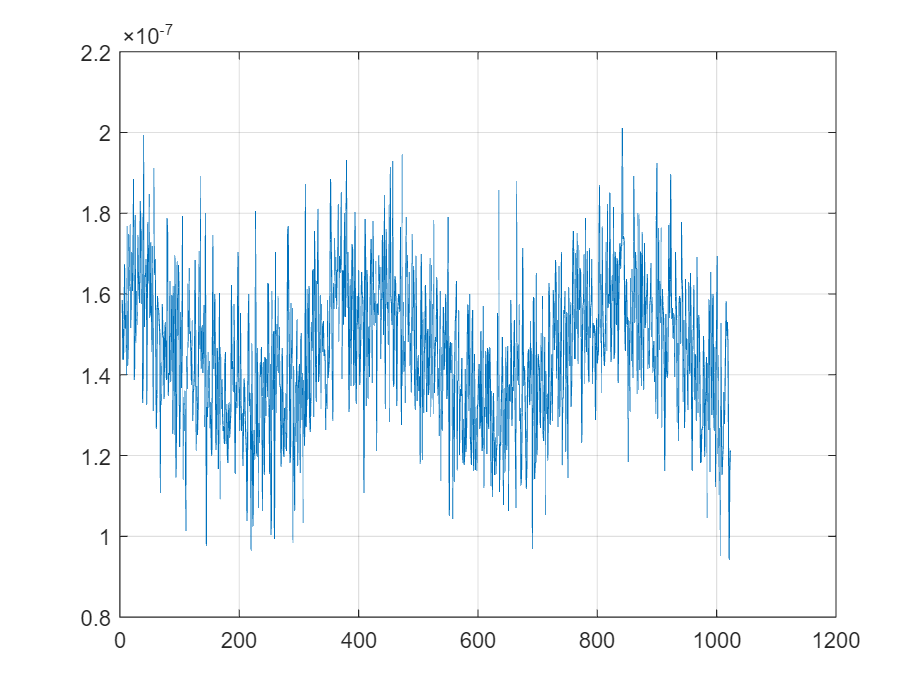

In [33]:
% Plot the Results of the Simulations

close all;
figure(1);
plot(bwpOffset:bwpOffset+12*numRBs-1, squeeze(abs(H(4, 1, 1,:))));
% semilogy(SNRdB, codedBERhard, LineStyle="--", LineWidth = 1.5, Marker= "P", MarkerSize=8)
% semilogy(SNRdB, codedBERsoft, LineStyle=":", LineWidth = 1.5, Marker= "+", MarkerSize=10)
% ylim([0.0001,0.2])
% legend('Uncoded-BER', 'Hard Decoding', 'Soft Decoding')
grid on;

In [34]:
size(H)

ans = 1x4    
          18         200          16        1020

## ToA Estimation

In [37]:
toaEstimation = ToAEstimation("ESPRIT", [int32(12*numRBs) int32(Nr)])
ToAe          = zeros(nBSs,nUEs);
Lpath         = int32(3);

for nbs=1:nBSs
    for nue =1:nUEs
        % disp("(nbs, nue): ("+num2str(nbs)+", "+num2str(nue)+")")
        delayEstimates = sort(double(toaEstimation(np.array(squeeze(H(nbs,nue,:,:)).'), Lpath, subCarrierSpacing = scs)));
        delayEstimates = delayEstimates(delayEstimates > 0);
        % K = Lpath
        % while((delayEstimates.size==0) or (delayEstimates[0]<=0 and K < 12)):
        %     K = K + 1
        %     delayEstimates = np.sort(toaEstimation(Hfint[nbs, nue].reshape(-1,overSamplingFactor*12*numRBs).T,
        %                                            numberOfPath = K,
        %                                            subCarrierSpacing = scs/overSamplingFactor))
        %     delayEstimates = delayEstimates[delayEstimates > 0]
        if(numel(delayEstimates) == 0)
            ToAe(nbs, nue) = 10^-9;
        else
            ToAe(nbs, nue) = delayEstimates(1);
        end

    end
end


## Position Estimation

In [42]:

rxStdEstimate      = zeros(nUEs,1);
kBestIndices       = zeros(nUEs, k);

%% Selection of k Most Accurate Measurements
% #################################################################
txPosition = double(simLayoutObj.BSLocations);
rxPosition = double(simLayoutObj.UELocations);
k          = 4;               % Select k-best measurements

Delays     = squeeze(double(channel.delays));
Delays     = squeeze(Delays(:,:,1));
error      = (abs(ToAe-Delays)./Delays); % Compute the ToA error in each measurement
[val, bsIndices] = sort(error,1);
bsIndices  = bsIndices(1:k,:);

positionEstimate = LeastSquareTDoA();
% % positionEstimate = LeastSquareToA()
% % Position Estimation Object:
%     % Positioning based on: TDoA
%     % Optimization Method: Least Square

rxPositionEstimate = zeros(nUEs,2,3);


for nue= 1:nUEs
    toa               = ToAe(bsIndices(:,nue),nue);
    tdoa              = toa(2:end) - toa(1);
    out = positionEstimate(np.array(txPosition(bsIndices(:,nue),:)), tdoa=np.array(tdoa));
    if numel(double(out{1})) == 3
        rxPositionEstimate(nue,:,:) = repmat(double(out{1}), 2,1);
    else
        rxPositionEstimate(nue,:,:) = double(out{1});
    end
    rxStdEstimate(nue)          = double(out{2});
%     rxPositionEstimate[nue], rxStdEstimate[nue] = positionEstimate(txPosition[bsIndices[nue]], toa)
    % disp("nue: "+num2str(nue)+" | Rx Location Estimate: "+num2str(rxPositionEstimate(nue,1,:)));
end


## Performance Evaluation


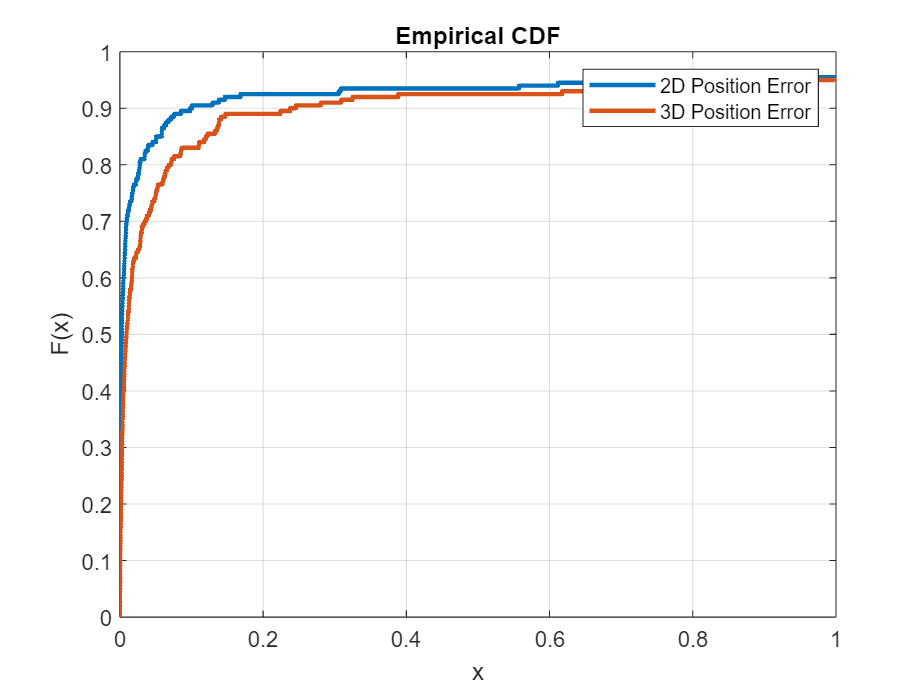

In [43]:
error = (rxPosition - squeeze(rxPositionEstimate(:,1,:))).^2;
posError2D = (sqrt(sum(error(:,1:2),2)));
posError3D = (sqrt(sum(error,2)));

close all;
figure(2)
h = cdfplot(posError2D);
set(h,'LineWidth',2)
hold on;
h = cdfplot(posError3D);
set(h,'LineWidth',2)
xlim([0,1]);
legend('2D Position Error','3D Position Error');
hold on;




!!!EndOutputRegion!!!